In [27]:
# 3/26/24 Quantum Approximate Optimization Algorithm (QAOA) Fermionic Swap Proxy 13 qubits
# importing all required libraries
import supermarq
import qiskit
import qiskit_superstaq as qss
from qiskit.visualization import plot_histogram
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# defining all the variables here
Q = 13 # number of qubits
f = 0.1 # defining predetermined frequency value
R = 100 # Predetermined optimal atom replenishing value given by my mentor
S = Q * R # finding number of shots a circuit needs to run in total while assuming a linear relationship between qubits and shots
x = f * S # calculating increment proportional to total number of shots (S)
nc = x # setting unchanging value for the loop
time = 30 # setting the normalization value
filename = "qaoa_f_swap" # setting universal filename to avoid having to set differently
foldername = "QAOA Fermionic Swap Proxy" + " " + str(Q) # setting universal folder name to avoid having to change it anywhere else
benchmark = "SupermarQ" # setting universal benchmark name to avoid having to change it everywhere else
bs_var_dict = {} # empty dict to hold all values of bs_var to see how it changes over time
p_var_dict = {} # empty dict to hold all vaues of p_var to see how it changes over time
score_dict = {} # dict that will observe the score at each shot interval

# added variance function instead of having to run it seperately
def variance(shots, b_name, fo_name, f_name):
    # load the output distribution from the json file
    file_path = '/home/aadi/Documents/Neutral-Atom-Technology/Step 2/' + str(b_name) + '/' + str(fo_name) + '/' + str(f_name) + '_counts_' + str(shots) + '_shots.json' 
    with open(file_path, 'r') as file:
        output_distribution = json.load(file)

    # convert the dictionary keys to a list and probabilities to a separate list
    states = list(output_distribution.keys())
    probabilities = list(output_distribution.values())

    # checks if probability value is more than one. If so, then it makes it proportional to what it should be
    # for w in probabilities:
    #     if w > 1:
    #         w = w//shots
    #     else:
    #         break
    #     break

    # this sets the probability values to add up to 1
    probabilities = [float(x)/float(shots) for x in probabilities]
    
    # random sampling of basis states based on probability and setting them equal to a list
    sample = np.random.choice(states, size=shots, p=probabilities)

    # random sampling of the probabilites list based on probabilty and setting them equal to a list
    prob_sample = np.random.choice(probabilities, size=shots, p=probabilities)

    # change binary to ints
    # int_sample = [int(b.replace(" ", ""), 2) for b in sample]
    int_sample = [int(b, 2) for b in sample]

    # calculating the variance and printing out the results
    sample_var = np.var(int_sample)
    # print("The sample variance is: " + str(sample_var))
    prob_var = np.var(prob_sample)
    # print("The sample variance using probability is : " + str(prob_var))
    
    return int(sample_var), prob_var

In [28]:
# connecting api key from my account to simulate the circuits
api_key = "6a4b1af32eae153aa46cb3e765dfee451c455020013623dc41f3896f959fd6c6"
provider = qss.SuperstaqProvider(api_key)
print(provider.get_balance())

20.00 credits


In [29]:
# defining which circuit I want to use and how many qubits
qc = supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy(num_qubits=Q)
qc_circuit = qc.qiskit_circuit()


# simple while loop to calculate 
while x <= S:
    
    bs_var = 0 # variance using basis states converted into integers
    p_var = 0 # variance using probability 
    avg_bs_var = 0 # variable to calculate average variance of basis state 
    avg_p_var = 0 # variable to calculate average variance of proabilty

    # executing the circuit via backend
    backend = provider.get_backend("ibmq_statevector_simulator")
    job_qss = backend.run(qc_circuit, shots=x, method="dry-run")

    # gettng the results of the simulationg 
    job = job_qss.result()

    # getting the counts and printing them
    counts = job.get_counts()
    # print("\n"counts)

    # measuring and getting accuracy of the result (like R^2 the closer to 1.0, the most faithful prediciton)
    score = qc.score(counts)
    
    
    score_dict[str(int(x))] = score
    

    # printing shot number to follow along
    # print(str(x))

    # logging the counts to a json file
    with open(filename + '_counts_' + str(int(x)) + '_shots.json', 'w', encoding='utf-8') as f:
        json.dump(counts, f, ensure_ascii=False, indent=4)

    # calculating the variance and normalizing it by running it 30 times and averaging it
    for t in range(1, time+1):
        temp_bs_var, temp_p_var = variance(int(x), benchmark, foldername, filename)
        bs_var += temp_bs_var
        p_var += temp_p_var
        avg_bs_var = int(bs_var / t)
        avg_p_var = p_var / t

    
    # adding the variance to the appropriate shot interval number
    bs_var_dict[str(int(x))] = avg_bs_var
    p_var_dict[str(int(x))] = avg_p_var

    # print("\nThe average variance using probability is: " + str(avg_p_var))
    # print("The average variance using basis state converted to integers is: " + str(avg_bs_var))

    # moving up an increment
    x += nc

print(bs_var_dict)
print(p_var_dict)

# setting the simulator that we will use to simulate our circuit (the default is ss_unconstrained_simulator)


{'130': 5149316, '260': 4809384, '390': 4743826, '520': 4733912, '650': 5000448, '780': 4791918, '910': 4764751, '1040': 5022350, '1170': 4959679, '1300': 4921029}
{'130': 1.5799166695843983e-05, '260': 3.7705335364074557e-06, '390': 5.078144057560435e-06, '520': 4.109482773712405e-06, '650': 3.5559765180957716e-06, '780': 2.395262799728486e-06, '910': 3.5332712280604383e-06, '1040': 1.6873688559410124e-06, '1170': 2.820887336116671e-06, '1300': 2.5791704888951134e-06}


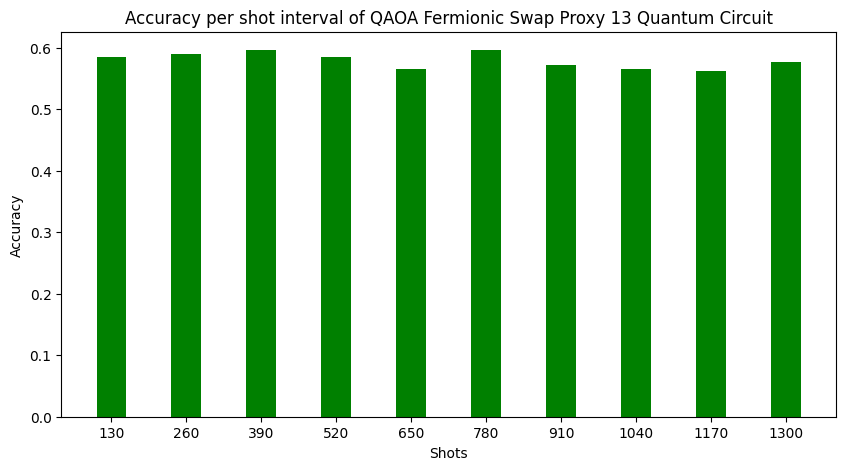

In [30]:
# bar graph of the accuracy during each shot interval
shots = list(score_dict.keys())
accuracy = list(score_dict.values())

# setting the plot size
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(shots, accuracy, color ='green', 
        width = 0.4)

# labeling the plot appropriately 
plt.xlabel("Shots")
plt.ylabel("Accuracy")
plt.title("Accuracy per shot interval of " + foldername + " Quantum Circuit")
plt.show()

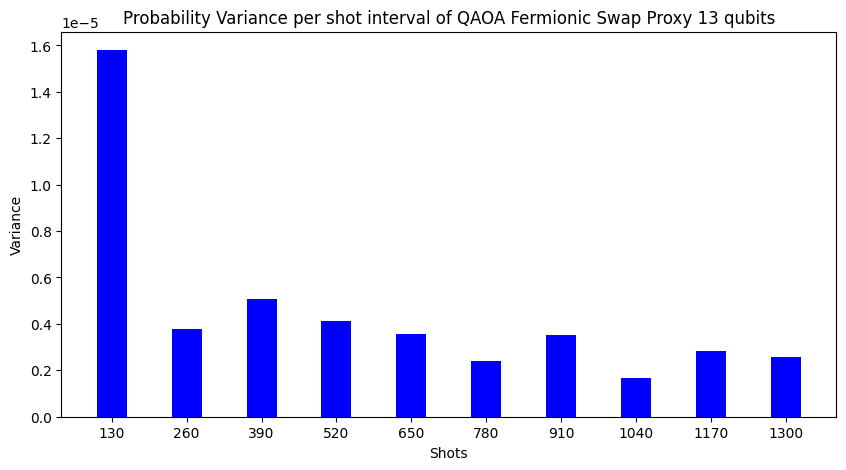

In [31]:
# splitting by counts and variance of probability dictionary
shots = list(p_var_dict.keys())
variance = list(p_var_dict.values())

# setting the plot size
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(shots, variance, color ='blue', 
        width = 0.4)

# labeling the plot appropriately 
plt.xlabel("Shots")
plt.ylabel("Variance")
plt.title("Probability Variance per shot interval of " + foldername + " qubits")
plt.show()

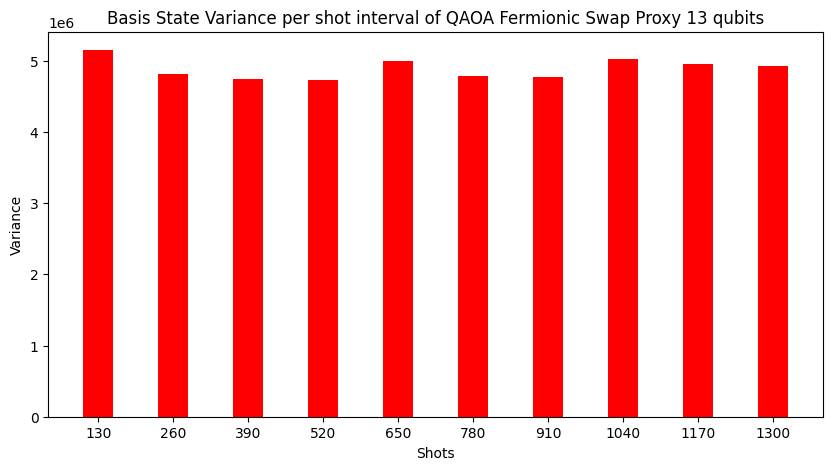

In [32]:
# splitting by counts and variance of probability dictionary
shots = list(bs_var_dict.keys())
variance = list(bs_var_dict.values())

# setting the plot size
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(shots, variance, color ='red', 
        width = 0.4)

# labeling the plot appropriately 
plt.xlabel("Shots")
plt.ylabel("Variance")
plt.title("Basis State Variance per shot interval of " + foldername + " qubits")
plt.show()